In [1]:
temporal = 5
seq = 300
static = 5 + 14*14

f"{(temporal*seq)+static} x {temporal+static}"

'1701 x 206'

In [2]:
is_skip = True

# Data params
batch_size = 32
# batch_size = 16
pred_len = 30

# Model params
d_model = 128
nhead = 4
d_ff = 256
dropout = 0.1
num_layers = 4

# Import

In [3]:
import os
import joblib
import copy
import time
import math

from tqdm import tqdm
from IPython.display import clear_output
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import seaborn as sns
import holidays

import torch
from transformers import BertConfig, BertTokenizer, BertModel
from pytorch_model_summary import summary

from PIL import Image
from torchvision import transforms
import cv2
from transformers import ViTImageProcessor, MobileViTModel, MobileViTConfig, ViTModel, AutoImageProcessor, ViTConfig, BertModel, BertTokenizer, DistilBertModel, DistilBertTokenizer
from skimage import io

device = torch.device("cuda:0")
# device = torch.device("cpu")
tqdm.pandas()

/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data

### Read

In [4]:
if not is_skip:
    us_holiday = holidays.US()
    
    # Read transaction
    df_trans = pd.read_csv("../HnM/transactions_train.csv", parse_dates=["t_dat"], dtype={"article_id":str})
    df_meta = pd.read_csv("../HnM/articles.csv", dtype={"article_id":str})

    min_year = df_trans["t_dat"].dt.year.min()
    max_year = df_trans["t_dat"].dt.year.max()

    holiday = holidays.US(years=(min_year, max_year))
    holiday = pd.DataFrame({"t_dat":holiday.keys(), "holiday":holiday.values()})
    holiday["t_dat"] = pd.to_datetime(holiday["t_dat"])

In [5]:
def preprocess(data):
    data = data.copy()

    # Image path
    data["img_path"] = data["article_id"].apply(lambda x: f'../HnM/resized_images/{x[:3]}/{x}.jpg')
    data["is_valid"] = data["img_path"].apply(lambda x: 1 if os.path.isfile(x) else 0) # Check whether the article has corresponding image file
    data = data[data["is_valid"] == 1].drop("is_valid", axis=1) # Valid if having corresponding image

    # Make sales
    data = data.groupby(["t_dat", "article_id", "img_path"], as_index=False).agg(sales=("customer_id", "count"), price=("price", "mean"))
    data["size"] = data.groupby(["article_id"], as_index=False)["sales"].transform("count")
    data = data[(data["size"]>=10)]

    # Expand dates
    data = data.set_index("t_dat").groupby(["article_id"], as_index=False).resample("1D").asfreq().reset_index()
    data["sales"] = data["sales"].fillna(0)
    data["price"] = data["price"].fillna(method="ffill")
    data["article_id"] = data["article_id"].fillna(method="ffill")
    data["img_path"] = data["img_path"].fillna(method="ffill")
    data = data.sort_values(["article_id", "t_dat"])
    
    data["size"] = data.groupby(["article_id"], as_index=False)["sales"].transform("count")
    data = data[(data["size"]>=pred_len*2)]
    data["time_idx"] = data.groupby("article_id").cumcount()
    data["time_idx"] = data["size"] - data["time_idx"]

    # Make holidays
    data = pd.merge(data, holiday, on="t_dat", how="left")
    display(data)

    # Temporal information
    # Make sure the sequence start from 0
    data["day"] = data["t_dat"].dt.day - 1
    data["dow"] = data["t_dat"].dt.dayofweek
    data["month"] = data["t_dat"].dt.month - 1
    data["year"] = data["t_dat"].dt.year / (data["t_dat"].dt.year.max() + 1)

    # Append meta data
    data = data.merge(df_meta[["index_name", "article_id", "colour_group_name", "graphical_appearance_name", "product_type_name"]], on="article_id")

    # Split
    df_train = data[data["time_idx"] > 30].copy()
    df_train["time_idx"] = df_train["time_idx"] - 30
    df_valid = data.copy()

    # Output
    return df_train.reset_index(drop=True), df_valid.reset_index(drop=True)

if not is_skip:
    df_prep = df_trans.copy()#.iloc[:1000]
    df_train, df_valid = preprocess(df_prep)
    
    df_train.to_parquet("df_train.pq")
    df_valid.to_parquet("df_valid.pq")

### Dataset

In [6]:
class LogScaler(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    
    def transform(self, x, y=None):
        return np.log1p(x)
    
    def inverse_transform(self, x, y=None):
        return np.expm1(x)
    
class NoneScaler(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    
    def transform(self, x, y=None):
        x = x.copy()
        return x
    
    def inverse_transform(self, x, y=None):
        x = x.copy()
        return x

In [7]:
class CustomLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mapper = {}
        self.idx = 0

    def fit(self, x, y=None):
        x = set(x)
        for val in x:
            if val not in self.mapper.keys():
                self.mapper[val] = self.idx
                self.idx += 1
        return self
    
    def transform(self, x, y=None):
        res = []
        for val in x:
            if val in self.mapper.keys():
                res.append(self.mapper[val])
            else:
                res.append(self.idx)
        return np.array(res)

In [8]:
df_train = pd.read_parquet("df_train.pq")
df_valid = pd.read_parquet("df_valid.pq")

df_train = df_train[df_train["index_name"] == "Ladieswear"]
df_valid = df_valid[df_valid["index_name"] == "Ladieswear"]

fake_val = -99
fake_mask_val = 0
real_mask_val = 1
padding_mask_val = 2

class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, is_train=True, encoder_dict=None):
        # Define parameters
        self.is_train = is_train
        self.transform = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
        if is_train:
            self.holiday_encoder = CustomLabelEncoder()
            self.index_encoder = CustomLabelEncoder()
            self.color_encoder = CustomLabelEncoder()
            self.graphic_encoder = CustomLabelEncoder()
            self.product_encoder = CustomLabelEncoder()

            self.holiday_encoder.fit(data["holiday"])
            self.index_encoder.fit(data["index_name"])
            self.color_encoder.fit(data["colour_group_name"])
            self.graphic_encoder.fit(data["graphical_appearance_name"])
            self.product_encoder.fit(data["product_type_name"])
        else: 
            self.holiday_encoder = encoder_dict["holiday_encoder"]
            self.index_encoder = encoder_dict["index_encoder"]
            self.color_encoder = encoder_dict["color_encoder"]
            self.graphic_encoder = encoder_dict["graphic_encoder"]
            self.product_encoder = encoder_dict["product_encoder"]
            
        # Iterate each product
        self.data_li = []
        self.min_val, self.max_val = data["sales"].min(), data["sales"].max()
        data.groupby("article_id").progress_apply(lambda x: self.data_li.append(x))
    
    def get_encoder_dict(self):
        return {"holiday_encoder": self.holiday_encoder,
                "index_encoder": self.index_encoder,
                "color_encoder": self.color_encoder,
                "graphic_encoder": self.graphic_encoder,
                "product_encoder": self.product_encoder}

    def __len__(self):
        return len(self.data_li)
    
    def __getitem__(self, idx):
        # Obtain information about data for each
        data = self.data_li[idx]
        
        # Label encode
        data["holiday"] = self.holiday_encoder.transform(data["holiday"])
        data["index_name"] = self.index_encoder.transform(data["index_name"])
        data["colour_group_name"] = self.color_encoder.transform(data["colour_group_name"])
        data["graphical_appearance_name"] = self.graphic_encoder.transform(data["graphical_appearance_name"])
        data["product_type_name"] = self.product_encoder.transform(data["product_type_name"])

        # Name each and scale data
        sales_scaler, price_scaler = LogScaler(), NoneScaler()
        ## Sales information
        sales = sales_scaler.fit_transform(data["sales"].values.reshape(-1,1)).reshape(-1)
        y = sales_scaler.transform(data["sales"].values.reshape(-1,1)).reshape(-1)
        ## Temporal information
        dow = data["dow"].values
        month = data["month"].values
        holiday = data["holiday"].values
        price = price_scaler.fit_transform(data["price"].values.reshape(-1,1)).reshape(-1)
        ## Static information
        index_name = data["index_name"].values[[0]]
        colour_group_name = data["colour_group_name"].values[[0]]
        graphical_appearance_name = data["graphical_appearance_name"].values[[0]]
        product_type_name = data["product_type_name"].values[[0]]
        img_path = data["img_path"].values[0]
        img_raw = Image.open(img_path).convert("RGB")
        img_input = self.transform(img_raw, return_tensors="pt", train=False)["pixel_values"].squeeze(0)

        # Generate mask
        if self.is_train:
            # When training, mask random time steps
            data, mask = self.generate_mask(sales)
        else:
            sales, start_idx, end_idx, mask = self.generate_valid_mask(sales)
            dow = dow[start_idx:end_idx]
            month = month[start_idx:end_idx]
            holiday = holiday[start_idx:end_idx]
            price = price[start_idx:end_idx]
            y = y[start_idx:end_idx]
        
        return {"sales": torch.Tensor(sales), 
                "dow":torch.IntTensor(dow), "month":torch.IntTensor(month), "holiday":torch.IntTensor(holiday), "price":torch.Tensor(price),
                "index_name": torch.IntTensor(index_name), "colour_group_name": torch.IntTensor(colour_group_name), "graphical_appearance_name": torch.IntTensor(graphical_appearance_name), "product_type_name": torch.IntTensor(product_type_name), 
                "img_raw":img_raw, "img_input": img_input,
                "length": len(y), "mask": torch.IntTensor(mask),
                "y":torch.Tensor(y)}

    def generate_mask(self, data):
        index = np.arange(len(data)) # Index for each time step
        num_masks = int(len(data) * 0.2) # Amont of masked values------------------------------------
        candidate_idx = np.random.choice(index, num_masks, replace=False) # Indexes to be masked
        assert num_masks == len(candidate_idx), "Not enough masks"
        
        # Generate mask: 0 for valid, 1 for mask(, replacement, real), 2 for padding
        mask = []
        for i in index:
            if i in candidate_idx:
                if np.random.rand() < 1:
                    data[i] = fake_val
                    mask.append(fake_mask_val)
                else:
                    mask.append(real_mask_val)
            else: 
                mask.append(padding_mask_val)
        assert len(mask) == len(data)
        return data, mask

    def generate_valid_mask(self, data):
        start_idx = 0
        # end_idx = data.shape[0]
        end_idx = 90

        data = data[start_idx:end_idx]
        mask = np.zeros(len(data)) + 1
        data[-30:] = fake_val # Mask last 30 time steps
        
        mask[-30:] = 0

        assert len(mask) == len(data)

        return data, start_idx, end_idx, mask

def collate_fn(batch_li):
    # Get data
    sales = [batch["sales"] for batch in batch_li]
    dow = [batch["dow"] for batch in batch_li]
    month = [batch["month"] for batch in batch_li]
    holiday = [batch["holiday"] for batch in batch_li]
    index_name = [batch["index_name"] for batch in batch_li]
    colour_group_name = [batch["colour_group_name"] for batch in batch_li]
    graphical_appearance_name = [batch["graphical_appearance_name"] for batch in batch_li]
    product_type_name = [batch["product_type_name"] for batch in batch_li]
    price = [batch["price"] for batch in batch_li]
    length = [batch["length"] for batch in batch_li]
    mask = [batch["mask"] for batch in batch_li]
    
    img_raw = [batch["img_raw"] for batch in batch_li]
    img_input = torch.stack([batch["img_input"] for batch in batch_li])

    y = [batch["y"] for batch in batch_li]

    # Pad data
    # We determine whether each position is valid or mask or padding with only `mask`.
    # Therefore, padding value for others are irrelavent but matters only for `mask`
    sales = torch.nn.utils.rnn.pad_sequence(sales, batch_first=True)
    dow = torch.nn.utils.rnn.pad_sequence(dow, batch_first=True)
    month = torch.nn.utils.rnn.pad_sequence(month, batch_first=True)
    holiday = torch.nn.utils.rnn.pad_sequence(holiday, batch_first=True)
    price = torch.nn.utils.rnn.pad_sequence(price, batch_first=True)
    mask = torch.nn.utils.rnn.pad_sequence(mask, batch_first=True, padding_value=padding_mask_val)
    y = torch.nn.utils.rnn.pad_sequence(y, batch_first=True)
    
    return {"sales": sales, 
            "dow":dow, "month":month, "holiday":holiday, "price":price, 
            "index_name": torch.stack(index_name), "colour_group_name": torch.stack(colour_group_name), "graphical_appearance_name": torch.stack(graphical_appearance_name), "product_type_name": torch.stack(product_type_name),
            "length": torch.IntTensor(length), "mask":mask,
            "img_raw": img_raw, "img_input":img_input,
            "y":y}

train_dataset = Dataset(df_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, pin_memory=True, num_workers=16)
# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

valid_dataset = Dataset(df_valid, is_train=False, encoder_dict=train_dataset.get_encoder_dict())
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, pin_memory=True, num_workers=16)
# valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

for data in train_dataloader:
    print("sales:", data["sales"].shape)
    print("price:", data["price"].shape)
    print("dow:", data["dow"].shape)
    print("index_name:", data["index_name"].shape)
    print("img_input", data["img_input"].shape)
    print("y:", data["y"].shape)
    print("length:", data["length"].shape)
    break

100%|██████████| 21093/21093 [00:00<00:00, 26687.58it/s]


sales: torch.Size([32, 671])
price: torch.Size([32, 671])
dow: torch.Size([32, 671])
index_name: torch.Size([32, 1])
img_input torch.Size([32, 3, 224, 224])
y: torch.Size([32, 671])
length: torch.Size([32])


In [9]:
# for data in valid_dataloader:
#     print("sales:", data["sales"].shape)
#     print("price:", data["price"].shape)
#     print("mask:", data["mask"].shape)
#     print("y:", data["y"].shape)
#     print("length:", data["length"].shape)
#     break

# Architecture

### Helper

In [10]:
from einops.layers.torch import Rearrange, Reduce

class PositionalEncoding(torch.nn.Module):
    # PE(pos, 2i) = sin(pos/10000^{2i/d_model}), 
    # PE(pos, 2i+1) = cos(pos/10000^{2i/d_model})
    def __init__(self, max_len, d_model, dropout):
        super().__init__()
        self.dropout = torch.nn.Dropout(dropout)

        position = torch.arange(max_len).reshape(-1,1).to(device)
        i = torch.arange(d_model).to(device)//2
        exp_term = 2*i/d_model
        div_term = torch.pow(10000, exp_term).reshape(1, -1)
        self.pos_encoded = position / div_term

        self.pos_encoded[:, 0::2] = torch.sin(self.pos_encoded[:, 0::2])
        self.pos_encoded[:, 1::2] = torch.cos(self.pos_encoded[:, 1::2])

    def forward(self, x):
        output = x + self.pos_encoded[:x.shape[1], :]
        return self.dropout(output)

class FeedForward(torch.nn.Module):
    def __init__(self, d_model, d_ff, activation):
        super().__init__()
        self.linear1 = torch.nn.Linear(d_model, d_ff)
        self.linear2 = torch.nn.Linear(d_ff, d_model)
        self.dropout = torch.nn.Dropout()

        if activation == "relu":
            self.activation = torch.nn.ReLU()
        elif activation == "gelu":
            self.activation = torch.nn.GELU()

    def forward(self, x):
        x = self.linear2(self.dropout(self.activation(self.linear1(x))))
        return self.dropout(x)

class SalesEmbedding(torch.nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.sales_linear = torch.nn.Linear(1, d_model)
        self.pos_enc = PositionalEncoding(1000, d_model, dropout)
    
    def forward(self, sales):
        sales_linear = self.sales_linear(sales)
        sales_posenc = self.pos_enc(sales_linear)

        return sales_posenc

class TemporalEmbedding(torch.nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.dow_embedder = torch.nn.Embedding(7, d_model)
        self.month_embedder = torch.nn.Embedding(12, d_model)
        self.holiday_embedder = torch.nn.Embedding(train_dataset.holiday_encoder.idx + 1, d_model)
        self.price_linear = torch.nn.Linear(1, d_model)
    
        self.pos_enc = PositionalEncoding(1000, d_model, dropout)
    
    def forward(self, dow, month, holiday, price):
        dow_linear = self.dow_embedder(dow)
        month_linear = self.month_embedder(month)
        holiday_linear = self.holiday_embedder(holiday)
        price_linear = self.price_linear(price.unsqueeze(-1))

        dow_posenc = self.pos_enc(dow_linear)
        month_posenc = self.pos_enc(month_linear)
        holiday_posenc = self.pos_enc(holiday_linear)
        price_posenc = self.pos_enc(price_linear)

        temporal = torch.stack([dow_posenc, month_posenc, holiday_posenc, price_posenc], dim=-2)

        return temporal

class StaticEmbedding(torch.nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.index_embedder = torch.nn.Embedding(train_dataset.index_encoder.idx + 1, d_model)
        self.color_embedder = torch.nn.Embedding(train_dataset.color_encoder.idx + 1, d_model)
        self.graphic_embedder = torch.nn.Embedding(train_dataset.graphic_encoder.idx + 1, d_model)
        self.product_embedder = torch.nn.Embedding(train_dataset.product_encoder.idx + 1, d_model)
    
    def forward(self, index, color, graph, product):
        index_linear = self.index_embedder(index.squeeze())
        color_linear = self.color_embedder(color.squeeze())
        graphic_linear = self.graphic_embedder(graph.squeeze())
        product_linear = self.product_embedder(product.squeeze())

        static = torch.stack([index_linear, color_linear, graphic_linear, product_linear], dim=-2)

        return static

class ImgEmbedding(torch.nn.Module):
    def __init__(self, in_channels, patch_size, emb_size, img_size):
        self.patch_size = patch_size
        super().__init__()
        self.projection = torch.nn.Sequential(
            # using a conv layer instead of a linear one -> performance gains
            torch.nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )
        self.positions = torch.nn.Parameter(torch.randn((img_size // patch_size) **2 , emb_size))
        
    def forward(self, x):
        b, _, _, _ = x.shape
        x = self.projection(x)
        # add position embedding
        x += self.positions
        return x
    
class MultiheadBlockAttention(torch.nn.Module):
    def __init__(self, d_model, num_heads, dropout):
        super().__init__()
        self.d_model, self.num_heads = d_model, num_heads
        self.q_linear = torch.nn.Linear(d_model, d_model)
        self.k_linear = torch.nn.Linear(d_model, d_model)
        self.v_linear = torch.nn.Linear(d_model, d_model)

        self.dropout = torch.nn.Dropout(dropout)
    
    def forward(self, query, key, value, static_key=None, static_value=None):
        # Linear transform
        query = self.q_linear(query)
        key = self.k_linear(key)
        value = self.v_linear(value)

        # Split head
        batch_size, seq_len, _, d_model = query.shape
        query = query.view(batch_size, seq_len, -1, self.num_heads, d_model//nhead).permute(0,3,1,2,4)
        key = key.view(batch_size, seq_len, -1, self.num_heads, d_model//nhead).permute(0,3,1,2,4)
        value = value.view(batch_size, seq_len, -1, self.num_heads, d_model//nhead).permute(0,3,1,2,4)
        if static_key is not None:
            static_key = static_key.view(batch_size, 1, -1, self.num_heads, d_model//nhead).permute(0,3,1,2,4)
            static_value = static_value.view(batch_size, 1, -1, self.num_heads, d_model//nhead).permute(0,3,1,2,4)

        # Scaled dot product attention
        dot_prod = query @ key.permute(0,1,2,4,3)
        scaled_dot_prod = dot_prod / math.sqrt(d_model//nhead)
        if static_key is not None:
            static_dot_prod = query @ static_key.permute(0,1,2,4,3)
            static_scaled_dot_prod = static_dot_prod / math.sqrt(d_model//nhead)
            
            concat_static_scaled_dot_prod = torch.cat([scaled_dot_prod, static_scaled_dot_prod], dim=-1)
            attn_weight = torch.nn.functional.softmax(concat_static_scaled_dot_prod, dim=-1)

            key_weight = attn_weight[..., :scaled_dot_prod.shape[-1]]
            static_key_weight = attn_weight[..., -static_scaled_dot_prod.shape[-1]:]
            
            attn_output = (key_weight@value) + (static_key_weight@static_value)
            attn_output = attn_output.permute(0,2,3,1,4).reshape(batch_size, seq_len, -1, d_model)
        else:
            attn_weight = torch.nn.functional.softmax(scaled_dot_prod, dim=-1)
            attn_output = (attn_weight @ value).permute(0,2,3,1,4).reshape(batch_size, seq_len, -1, d_model)

        return self.dropout(attn_output), attn_weight

class MultiheadAttention(torch.nn.Module):
    def __init__(self, d_model, nhead, dropout, batch_first):
        super().__init__()
        self.mha = torch.nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=batch_first)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, query, key, value, key_padding_mask=None):
        attnoutput, attnweight = self.mha(query=query, key=key, value=value, key_padding_mask=key_padding_mask)
        return self.dropout(attnoutput), attnweight

class Encoder(torch.nn.Module):
    def __init__(self, d_model, d_ff, activation):
        super().__init__()
        self.norm1 = torch.nn.LayerNorm(d_model)
        self.norm2 = torch.nn.LayerNorm(d_model)

        if activation == "relu":
            self.activation = torch.nn.ReLU()
        
        self.feed_forward = FeedForward(d_model, d_ff, activation)
    
    def forward(self, embedding, attnoutput):
        x = self.norm1(embedding + attnoutput)
        x = self.norm2(x + self.feed_forward(x))

        return x

class MultimodalEncoder(torch.nn.Module):
    def __init__(self, d_model, d_ff, activation, is_first_temporal=False):
        super().__init__()
        self.is_first_temporal = is_first_temporal
        self.norm = torch.nn.LayerNorm(d_model)
        
        self.norm11 = torch.nn.LayerNorm(d_model)
        self.norm12 = torch.nn.LayerNorm(d_model)
        self.norm21 = torch.nn.LayerNorm(d_model)
        self.norm22 = torch.nn.LayerNorm(d_model)
        self.norm31 = torch.nn.LayerNorm(d_model)
        self.norm32 = torch.nn.LayerNorm(d_model)
        
        if not is_first_temporal :
            self.mha1 = MultiheadAttention(d_model, nhead, dropout, batch_first=True)
        else: 
            self.mha1 = MultiheadBlockAttention(d_model, nhead, dropout)
        self.mha2 = MultiheadAttention(d_model, nhead, dropout, batch_first=True)

        self.ff1 = FeedForward(d_model, d_ff, activation)
        self.ff2 = FeedForward(d_model, d_ff, activation)
        self.ff3 = FeedForward(d_model, d_ff, activation)

        self.concat_linear = torch.nn.Linear(d_model*2, d_model)

    def forward(self, tgt_embedding, tgt, memory1, memory2, memory1_key_padding_mask=None, memory2_key_padding_mask=None):
        tgt = self.norm(tgt_embedding + tgt)
        
        if not self.is_first_temporal:
            crossattnoutput1, crossattnweight1 = self.mha1(tgt, memory1, memory1, memory1_key_padding_mask)
            crossattnoutput1 = self.norm11(tgt + crossattnoutput1)
            crossattnoutput1 = self.norm12(crossattnoutput1 + self.ff1(crossattnoutput1))
        else:
            tgt = tgt.unsqueeze(1)
            crossattnoutput1, crossattnweight1 = self.mha1(tgt, memory1, memory1)
            crossattnoutput1 = self.norm11(tgt + crossattnoutput1)
            crossattnoutput1 = self.norm12(crossattnoutput1 + self.ff1(crossattnoutput1))
            crossattnoutput1 = crossattnoutput1.squeeze()

        tgt = tgt.squeeze()
        crossattnoutput2, crossattnweight2 = self.mha2(tgt, memory2, memory2, memory2_key_padding_mask)
        crossattnoutput2 = self.norm21(tgt + crossattnoutput2)
        crossattnoutput2 = self.norm22(crossattnoutput2 + self.ff2(crossattnoutput2))

        concat = torch.cat([crossattnoutput1, crossattnoutput2], dim=-1)
        concat = self.concat_linear(concat)

        output = self.norm31(crossattnoutput1 + crossattnoutput2 + concat)
        output = self.norm32(output + self.ff3(output))

        return output, crossattnweight1, crossattnweight2

class MultimodalDecoder(torch.nn.Module):
    def __init__(self, d_model, d_ff, nhead, dropout, activation):
        super().__init__()
        self.norm1 = torch.nn.LayerNorm(d_model)
        self.norm2 = torch.nn.LayerNorm(d_model)
        self.norm3 = torch.nn.LayerNorm(d_model)

        self.blockattn = MultiheadBlockAttention(d_model, nhead, dropout)

        self.ff = FeedForward(d_model, d_ff, activation)
    
    def forward(self, tgt_embedding, tgt, memory, static_memory):

        tgt = self.norm1(tgt_embedding + tgt.squeeze()).unsqueeze(1)
        output, weight = self.blockattn(query=tgt, key=memory, value=memory, static_key=static_memory, static_value=static_memory)

        output = self.norm2(output + tgt)
        output = self.norm3(output + self.ff(output))

        return output, weight
        
1==1

True

### Transformer

In [11]:
class Transformer(torch.nn.Module):
    def __init__(self, d_model, num_layers, nhead, d_ff, dropout):
        super().__init__()
        # Embedding
        self.sales_linear = SalesEmbedding(d_model)
        self.temporal_embedding = TemporalEmbedding(d_model)
        self.static_embedding = StaticEmbedding(d_model)
        self.img_embedding = ImgEmbedding(in_channels=3, patch_size=16, emb_size=d_model, img_size=224)

        # Self attention (pre-add&norm)
        self.sales_selfattn = MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.temporal_selfattn = MultiheadBlockAttention(d_model, nhead, dropout)
        self.static_selfattn = MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.img_selfattn = MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)

        # Simple encoding
        self.sales_encoding = Encoder(d_model, d_ff, activation="relu")
        self.temporal_encoding = Encoder(d_model, d_ff, activation="relu")
        self.static_encoding = Encoder(d_model, d_ff, activation="relu")
        self.img_encoding = Encoder(d_model, d_ff, activation="relu")

        # Multimodal encoding
        self.temporal_multimodalencoding = MultimodalEncoder(d_model, d_ff, activation="relu")
        self.static_multimodalencoding = MultimodalEncoder(d_model, d_ff, activation="relu", is_first_temporal=True)
        self.img_multimodalencoding = MultimodalEncoder(d_model, d_ff, activation="relu", is_first_temporal=True)

        # Multimodal decoding
        self.multimodal_decoder = MultimodalDecoder(d_model, d_ff, nhead, dropout, activation="relu")

        # Finalize
        self.output = torch.nn.Sequential(torch.nn.Linear(d_model, d_model), torch.nn.Linear(d_model, d_model), torch.nn.Linear(d_model, d_model), torch.nn.Linear(d_model, 1))

    def forward(self, sales, dow, month, holiday, price, index, color, graph, product, img, mask):
        temporal_kind = 4
        padding_mask = torch.where(mask==padding_mask_val, -torch.inf, 0)
        temporal_padding_mask = padding_mask.unsqueeze(-1).repeat(1,1,temporal_kind).view(padding_mask.shape[0], -1)
        # Embedding
        sales_embedding = self.sales_linear(sales.unsqueeze(-1))
        temporal_embedding = self.temporal_embedding(dow, month, holiday, price)
        static_embedding = self.static_embedding(index, color, graph, product)
        img_embedding = self.img_embedding(img)

        # Self attention (pre-add&norm)
        sales_selfattnoutput, sales_selfattnweight = self.sales_selfattn(sales_embedding, sales_embedding, sales_embedding, key_padding_mask=padding_mask)
        sales_encoding = self.sales_encoding(sales_embedding, sales_selfattnoutput)
        
        temporal_selfattnoutput, temporal_selfattnweight = self.temporal_selfattn(temporal_embedding, temporal_embedding, temporal_embedding)
        temporal_encoding = self.temporal_encoding(temporal_embedding, temporal_selfattnoutput)

        static_selfattnoutput, static_selfattnweight = self.static_selfattn(static_embedding, static_embedding, static_embedding)
        static_encoding = self.temporal_encoding(static_embedding, static_selfattnoutput)

        img_selfattnoutput, img_selfattnweight = self.img_selfattn(img_embedding, img_embedding, img_embedding)
        img_encoding = self.temporal_encoding(img_embedding, img_selfattnoutput)

        # Multimodal encoding
        bs, seq_len, temp_kind, d_model = temporal_encoding.shape
        temporal_multiencodingoutput, temporal_multiencodingweight1, temporal_multiencodingweight2 = self.temporal_multimodalencoding(tgt_embedding=temporal_embedding.view(bs, -1, d_model), tgt=temporal_selfattnoutput.view(bs, -1, d_model), memory1=static_encoding, memory2=img_encoding)
        static_multiencodingoutput, static_multiencodingweight1, static_multiencodingweight2 = self.static_multimodalencoding(tgt_embedding=static_embedding, tgt=static_selfattnoutput, memory1=temporal_encoding, memory2=img_encoding)
        img_multiencodingoutput, img_multiencodingweight1, img_multiencodingweight2 = self.img_multimodalencoding(tgt_embedding=img_embedding, tgt=img_selfattnoutput, memory1=temporal_encoding, memory2=static_encoding)

        # Multimodal decoding
        sales_encoding = sales_encoding.unsqueeze(2)
        temporal_multiencodingoutput = temporal_multiencodingoutput.view(bs, seq_len, temp_kind, d_model)
        static_multiencodingoutput = torch.cat([static_multiencodingoutput, img_multiencodingoutput], dim=1).unsqueeze(1)

        multimodal_decodingoutput, multimodal_decodingweight = self.multimodal_decoder(tgt_embedding=sales_embedding, tgt=sales_encoding, memory=temporal_multiencodingoutput, static_memory=static_multiencodingoutput)
        multimodal_decodingoutput = multimodal_decodingoutput.squeeze()
        
        output = self.output(multimodal_decodingoutput)

        return output.squeeze(), multimodal_decodingweight
    
model = Transformer(d_model, num_layers, nhead, d_ff, dropout)
model.to(device)
summary(model,
        data["sales"].to(device), 
        data["dow"].to(device), data["month"].to(device), data["holiday"].to(device), data["price"].to(device),
        data["index_name"].to(device),  data["colour_group_name"].to(device),  data["graphical_appearance_name"].to(device),  data["product_type_name"].to(device),
        data["img_input"].to(device),
        data["mask"].to(device),
        show_parent_layers=True, print_summary=True)

# model = torch.nn.DataParallel(model)

-------------------------------------------------------------------------------------------------------------------------------------
   Parent Layers                 Layer (type)                                            Output Shape         Param #     Tr. Param #
     Transformer             SalesEmbedding-1                                          [32, 671, 128]             256             256
     Transformer          TemporalEmbedding-2                                       [32, 671, 4, 128]           4,352           4,352
     Transformer            StaticEmbedding-3                                            [32, 4, 128]          18,816          18,816
     Transformer               ImgEmbedding-4                                          [32, 196, 128]         123,520         123,520
     Transformer         MultiheadAttention-5                          [32, 671, 128], [32, 671, 671]          66,048          66,048
     Transformer                    Encoder-6                 

'-------------------------------------------------------------------------------------------------------------------------------------\n   Parent Layers                 Layer (type)                                            Output Shape         Param #     Tr. Param #\n=====================================================================================================================================\n     Transformer             SalesEmbedding-1                                          [32, 671, 128]             256             256\n     Transformer          TemporalEmbedding-2                                       [32, 671, 4, 128]           4,352           4,352\n     Transformer            StaticEmbedding-3                                            [32, 4, 128]          18,816          18,816\n     Transformer               ImgEmbedding-4                                          [32, 196, 128]         123,520         123,520\n     Transformer         MultiheadAttention-5         

# Train

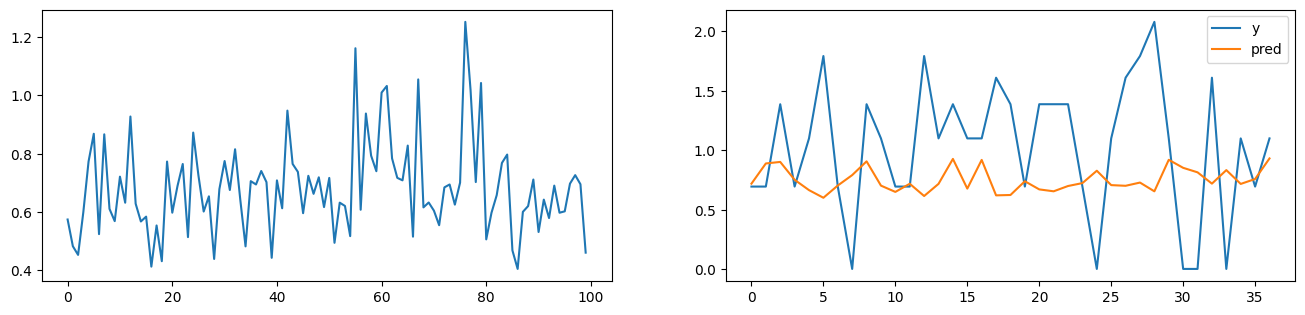

0 - loss: 0.6809432703256607, lr: 0.001:  48%|████▊     | 317/660 [00:48<00:52,  6.49it/s]


KeyboardInterrupt: 

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)
mse_loss = torch.nn.MSELoss(reduction="none")

def loss_fn(pred, y, mask):
    mask = torch.where((mask==fake_mask_val) | (mask==real_mask_val), 1, 0)
    loss = mse_loss(pred, y)
    loss = mask * loss
    loss = loss.sum()/mask.sum()
    return loss

def train(e):
    pbar = tqdm(train_dataloader)
    loss_li = []
    window = 100

    for n, data in enumerate(pbar):
        model.train()
        optimizer.zero_grad()
        pred, attn_weight = model(
                                data["sales"].to(device), 
                                data["dow"].to(device), data["month"].to(device), data["holiday"].to(device), data["price"].to(device),
                                data["index_name"].to(device),  data["colour_group_name"].to(device),  data["graphical_appearance_name"].to(device),  data["product_type_name"].to(device),
                                data["img_input"].to(device),
                                data["mask"].to(device),
                                )
        loss = loss_fn(pred, data["y"].to(device), data["mask"].to(device))
        loss.backward()
        optimizer.step()

        loss_li.append(loss.item())
        pbar.set_description(f"{e} - loss: {np.mean(loss_li[-window:])}, lr: {optimizer.param_groups[0]['lr']}")

        if n % 20 == 0:
            idx = 0
            plt.figure(figsize=(25,12))
            nrows, ncols = 3, 3
            clear_output(wait=True)

            # Loss
            plt.subplot(nrows, ncols, 1)
            plt.plot(loss_li[-window:])

            # Sample
            length = data["length"][idx]
            plt.subplot(nrows, ncols, 2)
            plt.plot(data["y"][idx][:length], label="y")
            plt.plot(pred[idx][:length].detach().cpu(), label="pred")
            plt.legend()

            # # Attn
            # plt.subplot(nrows, ncols, 4)
            # temp_attnweight = temp_attnweight.mean(dim=1)
            # sns.heatmap(temp_attnweight[idx].mean(dim=0).detach().cpu())
            # plt.title("temp_attnweight")

            # plt.subplot(nrows, ncols, 5)
            # sns.heatmap(sa_attnweight[idx].mean(dim=0).detach().cpu()[:, :length])
            # plt.title("sa_attnweight")

            # plt.subplot(nrows, ncols, 6)
            # sns.heatmap(cs_attnweight[idx].mean(dim=0).detach().cpu(), cbar=False)
            # plt.title("cs_attnweight")

            # plt.subplot(nrows, ncols, 7)
            # plt.imshow(data["img_raw"][idx])

            # plt.subplot(nrows, ncols, 8)
            # mask = torch.min(static_attnweight, dim=1).values
            # # mask = torch.mean(mask, dim=1)
            # mask = mask[:, 2, :]

            # mask = mask[idx, 4+1:]
            # mask = torch.nn.functional.softmax(mask, dim=-1).reshape(14,14).cpu().detach().numpy() # 28,28 or 14,14
            # mask = cv2.resize(mask / mask.max(), data["img_raw"][idx].size)[..., np.newaxis]
            # plt.imshow(mask)

            # plt.subplot(nrows, ncols, 9)
            # mask = torch.min(cs_static_attnweight, dim=1).values
            # # mask = torch.mean(mask, dim=1)
            # mask = mask[:, 2, :]

            # mask = mask[idx, 4+1:]
            # mask = torch.nn.functional.softmax(mask, dim=-1).reshape(14,14).cpu().detach().numpy() # 28,28 or 14,14
            # mask = cv2.resize(mask / mask.max(), data["img_raw"][idx].size)[..., np.newaxis]
            # plt.imshow(mask)

            plt.show()

epoch = 1
for e in range(epoch):
    train(e)
    scheduler.step()

# Eval

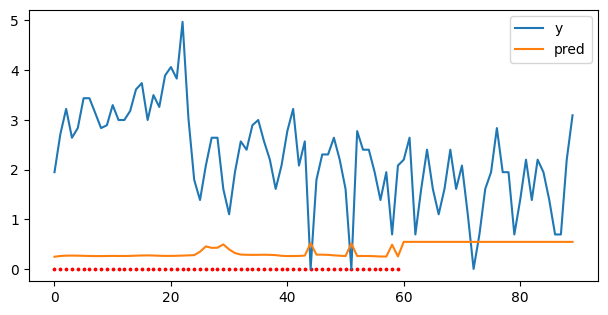

In [13]:
model.eval()
pbar = tqdm(valid_dataloader)

for n, data in enumerate(pbar):
    with torch.no_grad():
        sales = data["sales"].to(device)
        mask = data["mask"].to(device)
        pred, attn_weight = model(
                                data["sales"].to(device), 
                                data["dow"].to(device), data["month"].to(device), data["holiday"].to(device), data["price"].to(device),
                                data["index_name"].to(device),  data["colour_group_name"].to(device),  data["graphical_appearance_name"].to(device),  data["product_type_name"].to(device),
                                data["img_input"].to(device),
                                data["mask"].to(device),
                                )

        # for i in range(30):
        #     pred, pred_cat, temp_attnweight, sa_attnweight, cs_attnweight = model(
        #                                                                             data["sales"].to(device), 
        #                                                      
        #                        data["dow"].to(device), data["month"].to(device), data["holiday"].to(device), data["price"].to(device),
        #                                                                             data["mask"].to(device),
        #                                                                             )
            # idx = torch.argmax(mask, -1)
            # for n, i in enumerate(idx):
            #     sales[n, i] = pred[n, i]
            #     mask[n, i] = 0
        
        # idx = 0
        idx = data["y"][:, -1]
        idx = torch.argmax(idx)
        plt.figure(figsize=(25,12))
        nrows, ncols = 3, 3
        clear_output(wait=True)

        # Sample
        length = data["length"][idx]
        plt.subplot(nrows, ncols, 2)
        plt.plot(data["y"][idx][:length], label="y")
        plt.plot(pred[idx][:length].detach().cpu(), label="pred")
        plt.scatter(np.arange(data["mask"][idx][:length].shape[0]), torch.where(data["mask"][idx]==1, 0, np.nan)[:length], color="red", s=3)
        plt.legend()

        plt.show()
        input()